In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("="*80)
print("🔧 IMPROVED MODEL TRAINING")
print("="*80)

# Load data
print("\n1. Loading data...")
df = pd.read_excel('data.xlsx')
print(f"✅ Loaded {len(df)} records")

# Select necessary columns
selected_columns = [
    'Branch', 'Facility Type', 'FacilityAmount', 'Effective Rate',
    'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest',
    'ArrearsVat', 'ArrearsOD', 'FutureCapital', 'FutureInterest',
    'NET-OUTSTANDING', 'Status', 'NPLStatus', 'Last Receipt Paid Amount',
    'CD_Collection_Rental', 'ClaimablePercentage'
]

existing_columns = [col for col in selected_columns if col in df.columns]
df_filtered = df[existing_columns].copy()

🔧 IMPROVED MODEL TRAINING

1. Loading data...
✅ Loaded 188866 records


In [3]:
# Handle missing values
df_filtered.fillna(0, inplace=True)

# Calculate arrears ratio
df_filtered['Arrears_Ratio'] = (
    df_filtered['ArrearsCapital'] + df_filtered['ArrearsInterest']
) / (df_filtered['FacilityAmount'] + 1)

# IMPROVED LABELING - Stricter criteria
print("\n2. Creating performance labels with improved criteria...")
print("   Criteria for 'Poor' performance:")
print("   • Arrears Ratio > 10%")
print("   • More than 4 rentals in arrears")
print("   • NPL status = 1")
print("   • No recent payment + some arrears")
print("   • Capital arrears > 15% of facility")

df_filtered['Performance_Label'] = 'Good'

# Multiple conditions to mark as Poor
poor_conditions = (
    (df_filtered['Arrears_Ratio'] > 0.10) |  # >10% arrears
    (df_filtered['No of Rental in arrears'] > 4) |  # >4 rentals
    (df_filtered['NPLStatus'].astype(str).str.upper() == 'N') |  # NPLStatus 'N' means non-performing
    ((df_filtered['Last Receipt Paid Amount'] == 0) & 
     (df_filtered['No of Rental in arrears'] > 2)) |  # No payment + arrears
    (df_filtered['ArrearsCapital'] > df_filtered['FacilityAmount'] * 0.15)  # >15% capital arrears
)

df_filtered.loc[poor_conditions, 'Performance_Label'] = 'Poor'

print(f"\n✅ Label Distribution:")
label_counts = df_filtered['Performance_Label'].value_counts()
print(label_counts)
poor_pct = (label_counts.get('Poor', 0) / len(df_filtered)) * 100
print(f"   Poor percentage: {poor_pct:.2f}%")

# Handle severe class imbalance
good_count = (df_filtered['Performance_Label'] == 'Good').sum()
poor_count = (df_filtered['Performance_Label'] == 'Poor').sum()

if poor_count < good_count * 0.3 and poor_count > 100:  # If Poor < 30%
    print(f"\n⚠️ Class imbalance detected (Good: {good_count}, Poor: {poor_count})")
    print("   Balancing classes using undersampling...")
    
    df_good = df_filtered[df_filtered['Performance_Label'] == 'Good']
    df_poor = df_filtered[df_filtered['Performance_Label'] == 'Poor']
    
    # Undersample Good to create 2:1 ratio
    target_good = min(poor_count * 2, good_count)
    df_good_downsampled = resample(df_good, 
                                   replace=False,
                                   n_samples=target_good,
                                   random_state=42)
    
    df_filtered = pd.concat([df_good_downsampled, df_poor])
    df_filtered = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Balanced dataset:")
    print(df_filtered['Performance_Label'].value_counts())

# Encode categorical variables
print("\n3. Encoding categorical variables...")
# Use per-column encoders and explicit mapping for NPLStatus
encoders = {}
categorical_label_cols = ['Branch', 'Facility Type', 'Status']

for col in categorical_label_cols:
    if col in df_filtered.columns:
        le_col = LabelEncoder()
        df_filtered[f'{col}_encoded'] = le_col.fit_transform(df_filtered[col].astype(str))
        encoders[col] = le_col

# Explicit mapping for NPLStatus: 'N' => non-performing (1), 'P' => performing (0)
if 'NPLStatus' in df_filtered.columns:
    df_filtered['NPLStatus_encoded'] = (
        df_filtered['NPLStatus'].astype(str).str.upper().map({'N': 1, 'P': 0})
    ).fillna(0).astype(int)
    # Save mapping as a simple dict for later use
    encoders['NPLStatus'] = {'mapping': {'N': 1, 'P': 0}}

# Prepare features
feature_columns = [
    'Branch_encoded', 'Facility Type_encoded', 'FacilityAmount',
    'Effective Rate', 'No of Rental in arrears', 'Age',
    'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD',
    'FutureCapital', 'FutureInterest', 'NET-OUTSTANDING',
    'Status_encoded', 'NPLStatus_encoded', 'Last Receipt Paid Amount',
    'CD_Collection_Rental', 'ClaimablePercentage', 'Arrears_Ratio'
]

feature_columns = [col for col in feature_columns if col in df_filtered.columns]

X = df_filtered[feature_columns]
# Encode the target labels separately
target_le = LabelEncoder()
y = target_le.fit_transform(df_filtered['Performance_Label'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


2. Creating performance labels with improved criteria...
   Criteria for 'Poor' performance:
   • Arrears Ratio > 10%
   • More than 4 rentals in arrears
   • NPL status = 1
   • No recent payment + some arrears
   • Capital arrears > 15% of facility

✅ Label Distribution:
Performance_Label
Good    162583
Poor     26283
Name: count, dtype: int64
   Poor percentage: 13.92%

⚠️ Class imbalance detected (Good: 162583, Poor: 26283)
   Balancing classes using undersampling...
✅ Balanced dataset:
Performance_Label
Good    52566
Poor    26283
Name: count, dtype: int64

3. Encoding categorical variables...


In [4]:
print(f"\n✅ Data split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")
print(f"   Training class distribution: Good={np.sum(y_train==0)}, Poor={np.sum(y_train==1)}")
print(f"   Test class distribution: Good={np.sum(y_test==0)}, Poor={np.sum(y_test==1)}")

# Calculate class weight for balancing
# Recompute class counts after any balancing/resampling above
good_count = (df_filtered['Performance_Label'] == 'Good').sum()
poor_count = (df_filtered['Performance_Label'] == 'Poor').sum()
class_weight_ratio = good_count / max(poor_count, 1) if poor_count > 0 else 1



✅ Data split:
   Training: 63079 samples
   Test: 15770 samples
   Training class distribution: Good=42053, Poor=21026
   Test class distribution: Good=10513, Poor=5257


In [5]:
# Train models with class balancing
print("\n" + "="*80)
print("4. TRAINING MODELS WITH CLASS BALANCING")
print("="*80)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # Handles imbalance
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=class_weight_ratio,  # Balance classes
        random_state=42,
        eval_metric='logloss'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',  # Handles imbalance
        random_state=42,
        solver='liblinear'
    )
}

results = {}
best_accuracy = 0
best_model_name = ''

for name, model in models.items():
    print(f"\n{'-'*80}")
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
    
    print(f"\nAccuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Good', 'Poor']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Good    Poor")
    print(f"Actual Good   {cm[0][0]:4d}    {cm[0][1]:4d}")
    print(f"Actual Poor   {cm[1][0]:4d}    {cm[1][1]:4d}")
    
    # Calculate metrics
    if cm[1][1] + cm[1][0] > 0:
        poor_recall = cm[1][1] / (cm[1][1] + cm[1][0])
        print(f"\n🎯 Poor Detection Rate: {poor_recall:.2%} (of actual Poor cases)")



4. TRAINING MODELS WITH CLASS BALANCING

--------------------------------------------------------------------------------
Training Random Forest...

Accuracy: 0.9999

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     10513
        Poor       1.00      1.00      1.00      5257

    accuracy                           1.00     15770
   macro avg       1.00      1.00      1.00     15770
weighted avg       1.00      1.00      1.00     15770


Confusion Matrix:
                Predicted
              Good    Poor
Actual Good   10512       1
Actual Poor      0    5257

🎯 Poor Detection Rate: 100.00% (of actual Poor cases)

--------------------------------------------------------------------------------
Training XGBoost...

Accuracy: 0.9998

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     10513
        Poor       1.00      1.00      1.00    


5. Creating visualizations...
✅ Saved: improved_model_analysis.png

6. SAVING MODELS
✅ Models saved: models/all_models_package_20260104_003417.pkl
✅ Best model saved: models/best_model_20260104_003417.pkl

7. TESTING WITH SAMPLE INPUTS

Testing with Random Forest:

Perfect Case: Good (Confidence: 0.8051)
  Probabilities - Good: 0.8051, Poor: 0.1949

Poor Case: Poor (Confidence: 1.0000)
  Probabilities - Good: 0.0000, Poor: 1.0000

Critical Case: Poor (Confidence: 1.0000)
  Probabilities - Good: 0.0000, Poor: 1.0000

✅ TRAINING COMPLETE!

🏆 Best Model: Random Forest
📊 Accuracy: 0.9999

📁 Files saved:
   • models/all_models_package_20260104_003417.pkl
   • improved_model_analysis.png

🚀 Next steps:
   1. Restart your API: python api.py
   2. Test with the sample inputs again
   3. You should now see both 'Good' and 'Poor' predictions!


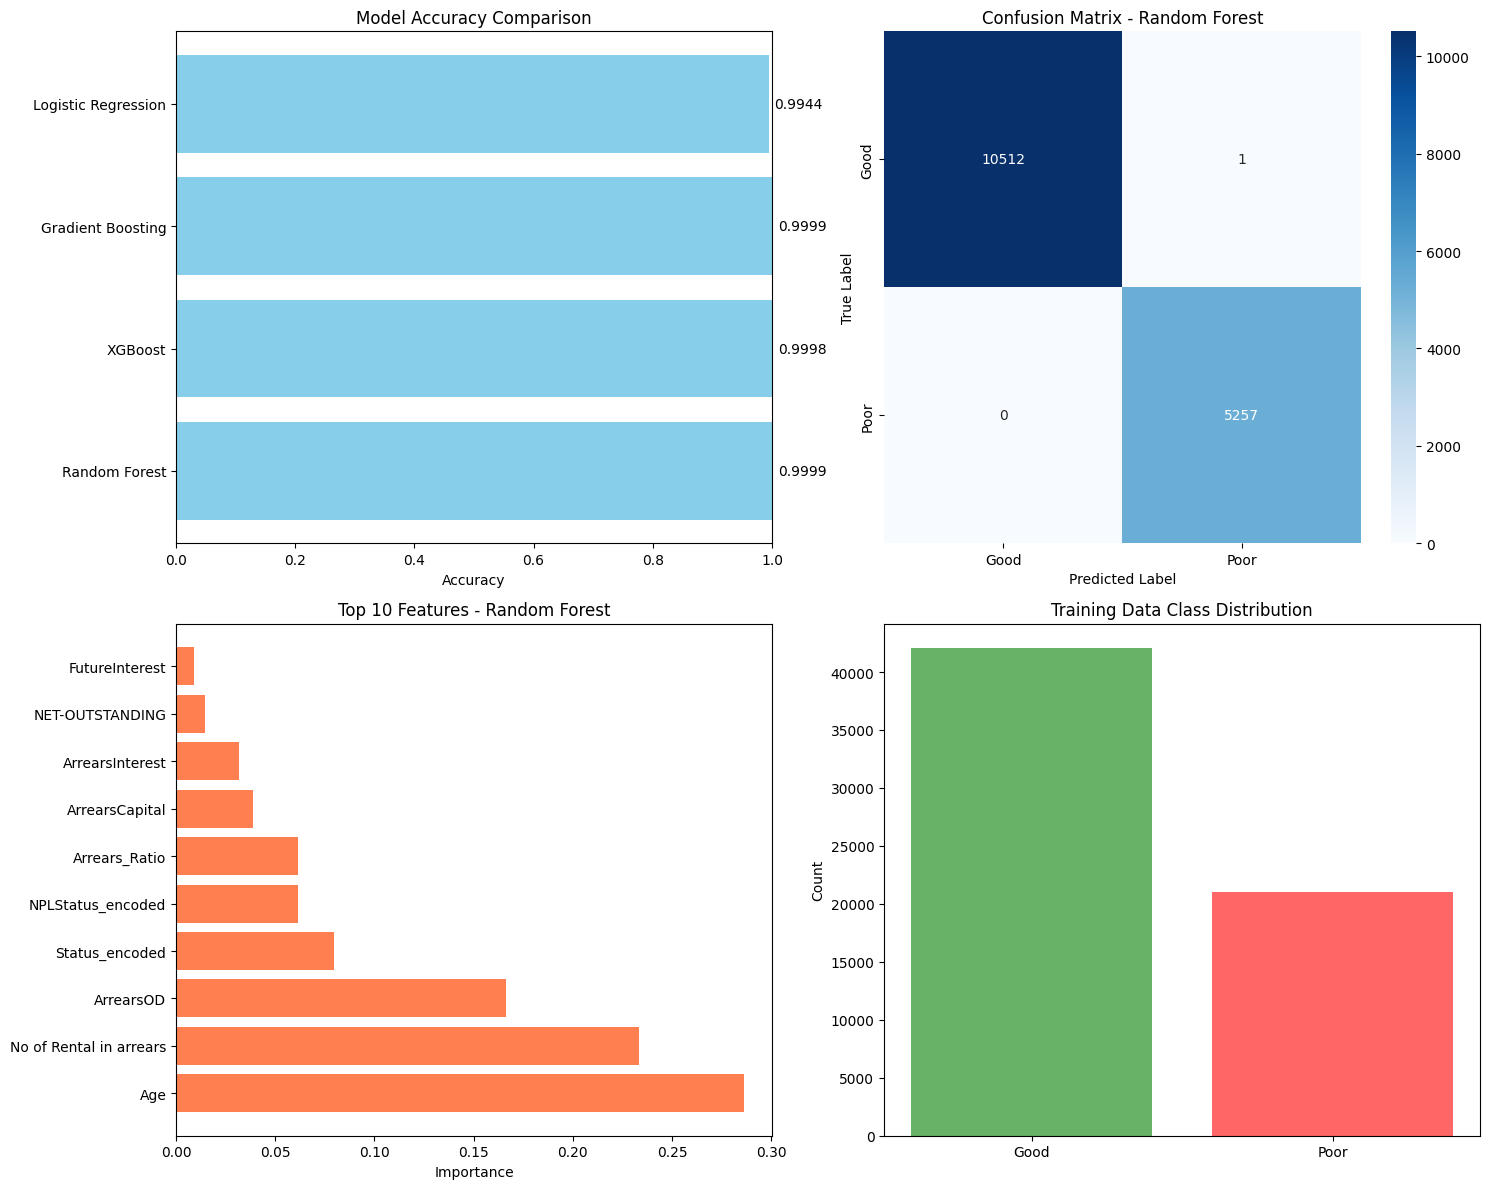

In [6]:
# Create visualization
print("\n5. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
ax1 = axes[0, 0]
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
ax1.barh(model_names, accuracies, color='skyblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_xlim([0, 1])
for i, v in enumerate(accuracies):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center')

# Best model confusion matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Good', 'Poor'], yticklabels=['Good', 'Poor'])
ax2.set_title(f'Confusion Matrix - {best_model_name}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Feature importance
ax3 = axes[1, 0]
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    ax3.barh(feature_importance['Feature'], feature_importance['Importance'], color='coral')
    ax3.set_xlabel('Importance')
    ax3.set_title(f'Top 10 Features - {best_model_name}')
else:
    ax3.text(0.5, 0.5, 'Feature importance\nnot available', 
             ha='center', va='center', fontsize=12)

# Class distribution
ax4 = axes[1, 1]
class_dist = pd.Series(y_train).value_counts()
ax4.bar(['Good', 'Poor'], [class_dist.get(0, 0), class_dist.get(1, 0)], 
        color=['green', 'red'], alpha=0.6)
ax4.set_ylabel('Count')
ax4.set_title('Training Data Class Distribution')

plt.tight_layout()
plt.savefig('improved_model_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: improved_model_analysis.png")

# Save models
print("\n" + "="*80)
print("6. SAVING MODELS")
print("="*80)

if not os.path.exists('models'):
    os.makedirs('models')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save all models package
all_models_data = {
    'models': {name: results[name]['model'] for name in results.keys()},
    'scaler': scaler,
    'feature_columns': feature_columns,
    'best_model_name': best_model_name,
    'encoders': encoders,
    'target_label_encoder': target_le,
    'model_comparison': {name: results[name]['accuracy'] for name in results.keys()},
    'timestamp': timestamp
}

filename = f"models/all_models_package_{timestamp}.pkl"
joblib.dump(all_models_data, filename)
print(f"✅ Models saved: {filename}")

# Save individual best model
best_filename = f"models/best_model_{timestamp}.pkl"
joblib.dump(results[best_model_name]['model'], best_filename)
print(f"✅ Best model saved: {best_filename}")

# Test with sample data
print("\n" + "="*80)
print("7. TESTING WITH SAMPLE INPUTS")
print("="*80)

test_cases = [
    ("Perfect Case", [1, 0, 2000000, 10.5, 0, 36, 0, 0, 0, 0, 1800000, 180000, 1980000, 0, 0, 50000, 50000, 100, 0.0]),
    ("Poor Case", [1, 0, 2000000, 16.5, 7, 30, 350000, 45000, 8000, 15000, 1200000, 150000, 1768000, 1, 1, 0, 0, 70, 0.209]),
    ("Critical Case", [1, 1, 1500000, 20.0, 15, 8, 500000, 80000, 10000, 30000, 800000, 120000, 1540000, 2, 1, 0, 0, 40, 0.413])
]

print(f"\nTesting with {best_model_name}:")
for name, data in test_cases:
    X_sample = scaler.transform([data])
    pred = results[best_model_name]['model'].predict(X_sample)[0]
    pred_label = 'Good' if pred == 0 else 'Poor'
    
    if hasattr(results[best_model_name]['model'], 'predict_proba'):
        proba = results[best_model_name]['model'].predict_proba(X_sample)[0]
        conf = max(proba)
        print(f"\n{name}: {pred_label} (Confidence: {conf:.4f})")
        print(f"  Probabilities - Good: {proba[0]:.4f}, Poor: {proba[1]:.4f}")
    else:
        print(f"\n{name}: {pred_label}")

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy:.4f}")
print(f"\n📁 Files saved:")
print(f"   • {filename}")
print(f"   • improved_model_analysis.png")
print(f"\n🚀 Next steps:")
print(f"   1. Restart your API: python api.py")
print(f"   2. Test with the sample inputs again")
print(f"   3. You should now see both 'Good' and 'Poor' predictions!")